In this project, I'm working with the Titanic dataset from Kaggle. The goal is to extract insights from the data and then check for outliers, inconsistent data, null values, and duplicated data for data cleaning purposes. Additionally, I'll perform preprocessing steps to prepare the data for machine learning tasks.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import (StandardScaler)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, make_scorer, f1_score

In [2]:
titanic = pd.read_csv("train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Overview 'Titanic-Machine Learning from Disaster'
- `PassengerId` is the unique id of the row and it doesn't have any effect on target
- `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
- `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**, **2** or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
- `Name`, `Sex` and `Age` are self-explanatory
- `SibSp` is the total number of the passengers' siblings and spouse
- `Parch` is the total number of the passengers' parents and children
- `Ticket` is the ticket number of the passenger
- `Fare` is the passenger fare
- `Cabin` is the cabin number of the passenger
- `Embarked` is port of embarkation and it is categorical feature which has 3 unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

## Exploration of Datas:

In [3]:
titanic.shape

(891, 12)

#### Let's examine the number of people who embarked from each port.

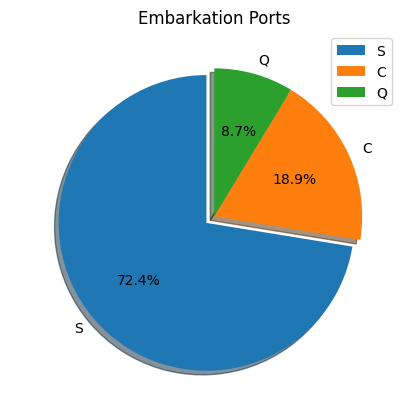

In [4]:
explode = (0.07, 0, 0)
titanic['Embarked'].value_counts().plot.pie(title="Embarkation Ports",
                                            legend=True, autopct='%1.1f%%', startangle=90,
                                            explode=explode, shadow=True)
plt.ylabel(' ')
plt.show()


Most of people embarked from Southampton. Very few of them are from Queenstown.

#### Let's see people how many people survived from each port.

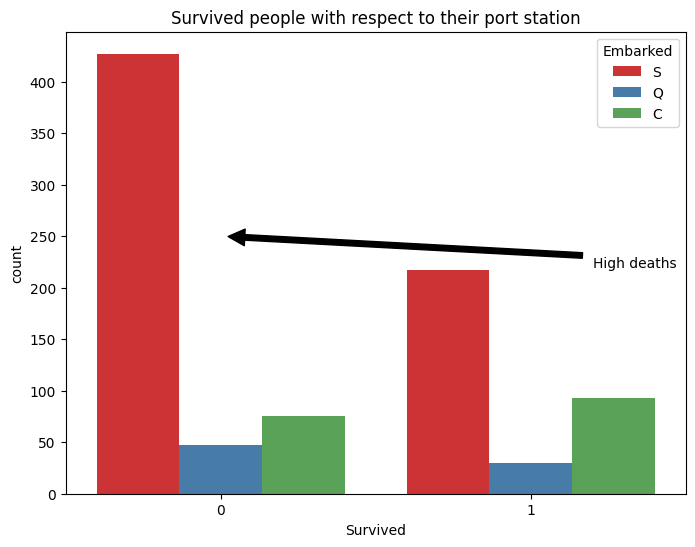

In [5]:
plt.figure(figsize=(8,6), dpi=100)
sns.countplot(x='Survived', data=titanic, hue='Embarked', palette='Set1')
plt.title('Survived people with respect to their port station')
plt.annotate('High deaths', xy=(0, 250), xytext=(1.2, 220),
             arrowprops=dict(facecolor='black', shrink=0.02))
plt.show()


From the figure, we can see that the majority of Titanic passengers embarked from Southampton, and a significant number of survivors also originated from there. In comparison, fewer passengers embarked from Queenstown and Cherbourg. Interestingly, the number of fatalities from these two ports combined is nearly half of those from Southampton.

#### Let's see which passenger class people survived the most.

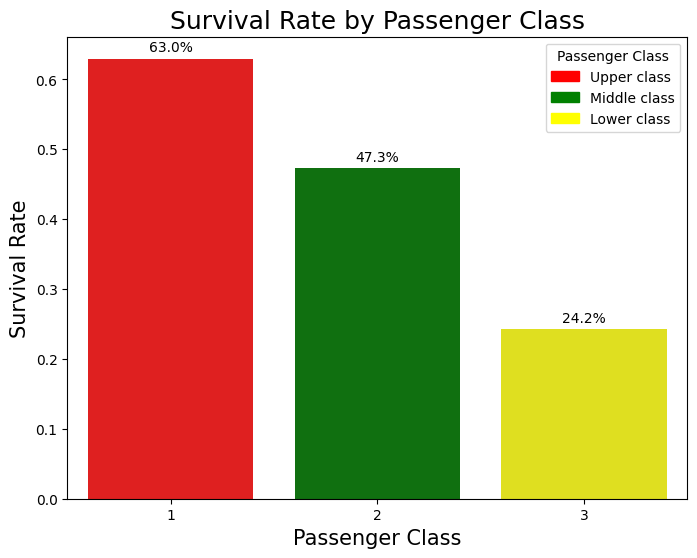

In [6]:
# Calculate survival rate by passenger class
survival_rate = titanic.groupby('Pclass')['Survived'].mean().reset_index()

# Define custom colors for each class
colors = {'Upper class': 'red', 'Middle class': 'green', 'Lower class': 'yellow'}

# Plotting
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='Pclass', y='Survived', data=survival_rate, palette=colors.values())
legend_handles = [Patch(color=color, label=label) for label, color in colors.items()]
plt.legend(handles=legend_handles, title='Passenger Class')
for i, pclass in enumerate(survival_rate['Pclass']):
    plt.text(i, survival_rate.loc[i, 'Survived'] + 0.01, f"{survival_rate.loc[i, 'Survived']*100:.1f}%", ha='center')
plt.ylabel('Survival Rate', fontsize=15)
plt.xlabel('Passenger Class', fontsize=15)
plt.title('Survival Rate by Passenger Class', fontsize=18)
plt.show()

The bar plot clearly shows that approximately 63% of passengers from the first class (Upper class) survived the Titanic disaster. In contrast, the majority of casualties were from the third class (Lower class). This suggests a strong correlation between passenger class and survival rate, indicating that passengers in higher classes had a higher likelihood of survival.

#### Which gender of people survived the most?

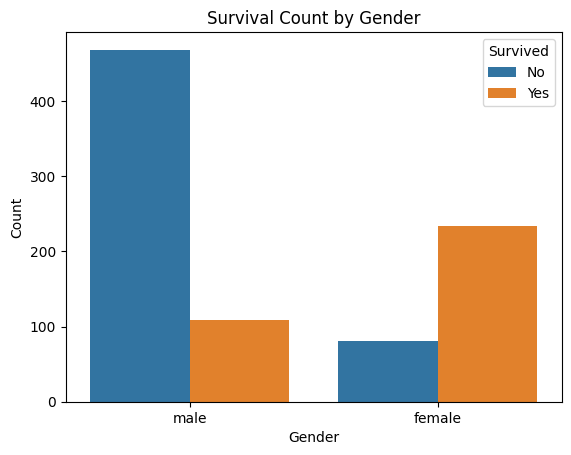

In [7]:
sns.countplot(x='Sex', hue='Survived', data=titanic)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Survival Count by Gender')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

The countplot clearly indicates that the majority of survivors from the Titanic disaster were female, while most of those who did not survive were male. Interestingly, more than 60% of males perished in the disaster.

In [8]:
# Let's see number wise.
print("Survival rate of male and female")
print(titanic.Sex.value_counts('Survived'))
print("\nHow many of male survived or died")
print(titanic[titanic['Sex']=='male'].value_counts('Survived'))
print("\nWhat portion of female survived or died")
print(titanic[titanic['Sex']=='female'].value_counts('Survived', normalize=True))


Survival rate of male and female
Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64

How many of male survived or died
Survived
0    468
1    109
Name: count, dtype: int64

What portion of female survived or died
Survived
1    0.742038
0    0.257962
Name: proportion, dtype: float64


<br>

#### Let's see how distributed is our age group.

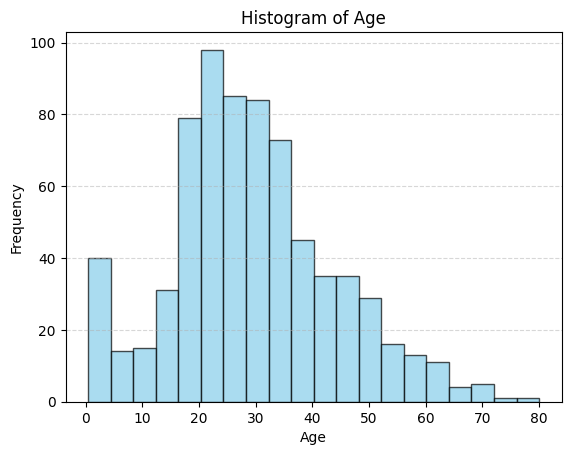

In [9]:
titanic["Age"].plot.hist(title="Histogram of Age", bins=20, color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

The histogram is skewed to the right, it indicates that there are more younger individuals in the dataset.

<br>

#### Which age group paid more more fare.

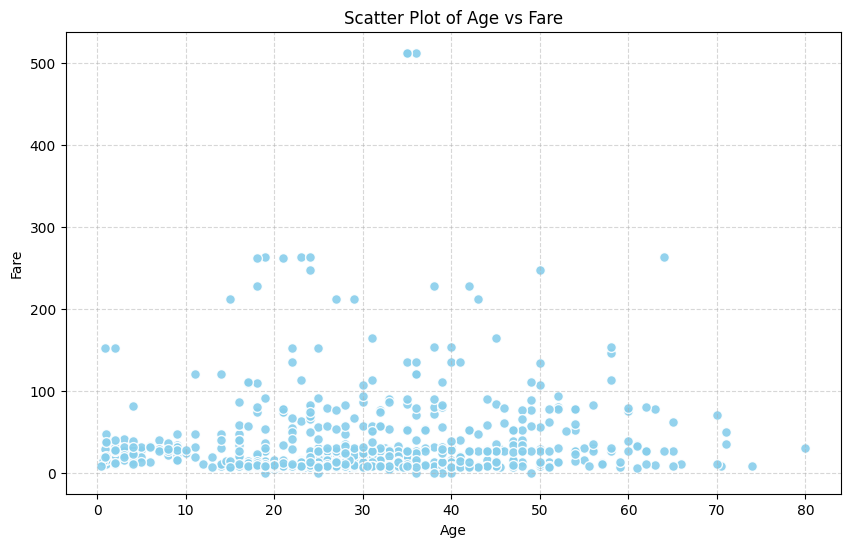

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(titanic["Age"], titanic["Fare"], color='skyblue', s=50, alpha=0.9, edgecolors='w')

plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Scatter Plot of Age vs Fare')

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

<br>

#### Correlation between different columns.

In [11]:
corr = titanic[['Survived', 'Pclass', 'Age', 'Fare']].corr()

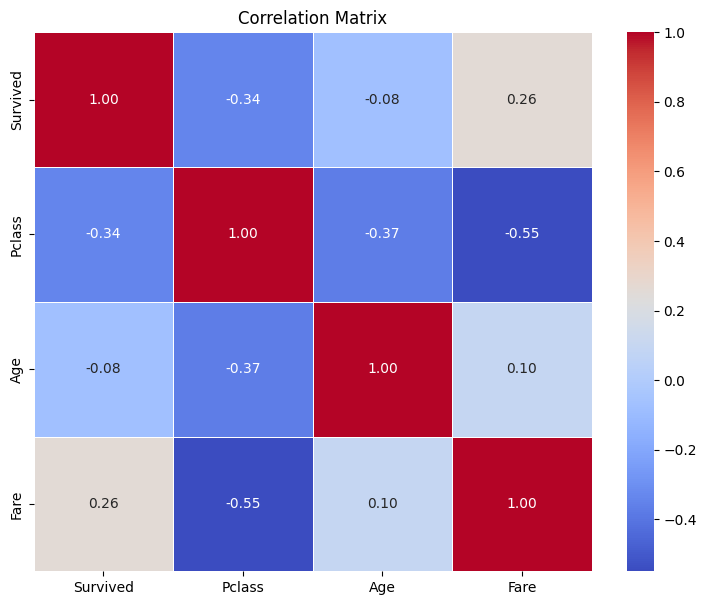

In [12]:
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In a correlation matrix heatmap, colors are used to represent the strength and direction of the relationship between features.
- Shades of red indicate a high positive correlation, suggesting that as one feature increases, the other tends to increase as well.
- Shades of blue represent a negative correlation, indicating that as one feature increases, the other tends to decrease.

The intensity of the color reflects the strength of the correlation. Darker shades signify a stronger correlation, while lighter shades indicate a weaker correlation. The diagonal of the heatmap is often a solid color (typically white) as it represents the correlation of a feature with itself, which is always perfect and not informative for analysis.

<br>

## Data Cleaning 

#### Dropping column which is not useful for us or for feature selection.

In [13]:
titanic.drop('PassengerId', axis=1, inplace=True)

#### Checking outliers.

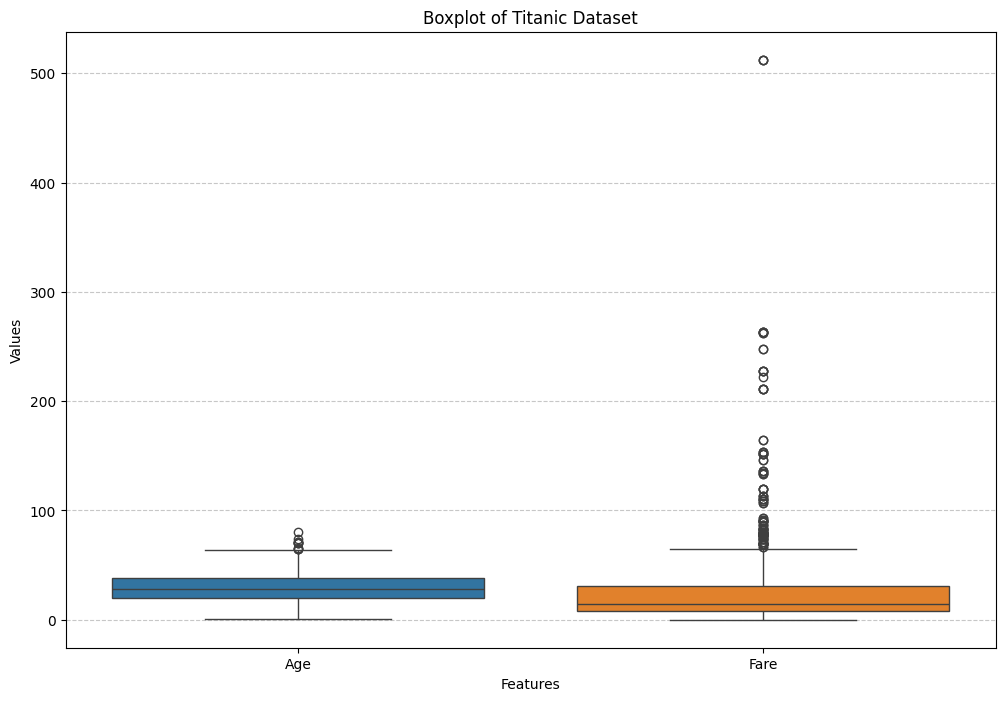

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=titanic[['Age', 'Fare']])
plt.title('Boxplot of Titanic Dataset')
plt.xlabel('Features')
plt.ylabel('Values')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Here we can see many outliers in the fair but this outliers could be useful for us in the future for proper model selection because if we remove all the ouliers it will decrease our data which is not good.

Handling outliers of column Age.

In [15]:
Q1 = titanic['Age'].quantile(0.25)
Q3 = titanic['Age'].quantile(0.75)
IQR= Q3-Q1
max_b = (1.5 * IQR) + Q3
min_b = Q1 - (1.5 * IQR)

to_drop_index = titanic['Age'][(titanic['Age'] > max_b) | (titanic['Age']< min_b)].index
print(to_drop_index)
titanic.drop(to_drop_index, axis=0, inplace=True)

print(f"Dropped {to_drop_index} : {max_b} | {min_b} : for column Age")

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')
Dropped Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64') : 64.8125 | -6.6875 : for column Age


### Checking duplicates

In [16]:
titanic.duplicated().sum()

0

### Handling Null Values.

In [17]:
titanic.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       681
Embarked      2
dtype: int64

#### Handling Embarked null values by adding null values with mode.

In [18]:
titanic['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode()[0])

#### Handling Age null values

First checking if there is any incorrect age or not.

In [19]:
incorrect_age = titanic[(titanic['Age'] <=0) | (titanic['Age'] > 100)]
incorrect_age.value_counts().sum()

0

**Replacing null values based on title initials (Mr., Mrs., Master, Miss) mean age in this dataset.**

**Before assigning titles, it's important to identify common initials for both males and females. In my exploration of the data, I noticed that the 'Dr.' title is used for individuals of both genders. To address this, I standardized the initials for females to 'dr.'"**

In [20]:
titanic.loc[796]

Survived                              1
Pclass                                1
Name        Leader, Dr. Alice (Farnham)
Sex                              female
Age                                49.0
SibSp                                 0
Parch                                 0
Ticket                            17465
Fare                            25.9292
Cabin                               D17
Embarked                              S
Name: 796, dtype: object

In [21]:
titanic.at[796, "Name"] = 'Leader, dr. Alice (Farnham)' # Dealing with 'gender' of Doctors.

In [22]:
def get_initials(value):
    name = value.split(',')[1]
    initials = name.split('.')[0]
    return initials.strip()

In [23]:
titanic['Initials'] = titanic['Name'].apply(get_initials)

In [24]:
titanic['Initials'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'the Countess', 'dr',
       'Jonkheer'], dtype=object)

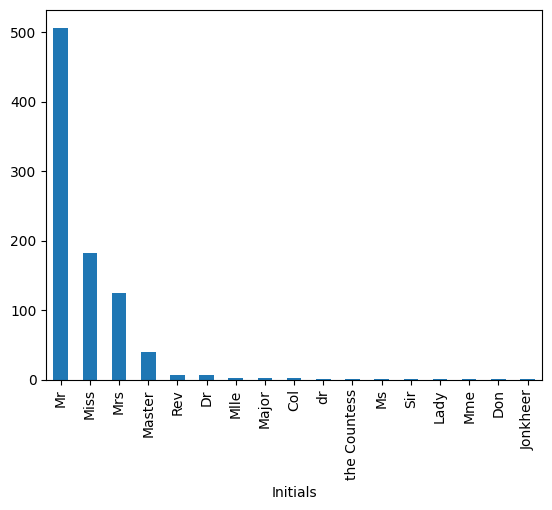

In [25]:
titanic['Initials'].value_counts().plot.bar()
plt.show()

In [26]:
titanic[(titanic.Initials == 'Dr') | (titanic.Initials == 'dr')]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initials
245,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Dr
317,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Dr
398,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Dr
632,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Dr
660,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Dr
766,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Dr
796,1,1,"Leader, dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,dr


#### Now replacing Initials with common initials.

In [27]:
titanic['Initials'].replace(to_replace={'Lady':'Miss', 'Sir':'Mr', 'Ms':'Miss', 'Dr':'Mr', 'Capt':'Mr', 'Col':'Mr', 'Mme':'Mrs', 
               'Don':'Mr', 'Rev':'Mr', 'Major':'Mr', 'Mlle':'Miss', 'the Countess':'Mrs', 
               'Jonkheer':'Master', 'dr':'Mrs'}, inplace=True)

In [28]:
grouped = titanic.groupby(by='Initials')

In [29]:
titanic['Initials'].value_counts()

Initials
Mr        525
Miss      186
Mrs       128
Master     41
Name: count, dtype: int64

In [30]:
grouped['Age'].agg(Nan=lambda x: x.isna().sum(), NoNan = lambda x: x.notna().sum())

,Nan,NoNan
Initials,,
Master,4,37
Miss,36,150
Mr,120,405
Mrs,17,111


In [31]:
median_age_by_initials_sex_Pclass = titanic.groupby(['Sex', 'Pclass', 'Initials'])['Age']
median_age_by_initials_sex_Pclass.median()

Sex     Pclass  Initials
female  1       Miss        30.0
                Mrs         40.0
        2       Miss        24.0
                Mrs         32.0
        3       Miss        18.0
                Mrs         31.0
male    1       Master       7.5
                Mr          40.0
        2       Master       1.0
                Mr          31.0
        3       Master       4.0
                Mr          26.0
Name: Age, dtype: float64

In [32]:
titanic.loc[titanic.Age.isna(), 'Age'] = titanic.groupby(
    ['Sex', 'Pclass', 'Initials'])['Age'].transform('median')

In [33]:
titanic['Age'].isna().sum()

0

#### Handling null values of Cabin. 
**Handling it in such a way that we are seating is regarded as 1 and who don't as 0.**

In [34]:
titanic['Cabin'] = titanic['Cabin'].fillna(0).map(lambda x: 1 if x != 0 else 0)

In [35]:
titanic.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
Initials    0
dtype: int64

In [36]:
target = titanic['Survived']
titanic.drop('Survived', axis=1, inplace=True)

<br>

In [37]:
titanic.drop(columns=['Name', 'Ticket', 'Initials'], axis=1, inplace=True)

In [38]:
titanic.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

### Data Encoding, Normalization

In [39]:
# OneHotEncoding
nominal_cols = ['Sex', 'Embarked']
encoded_onehot = pd.get_dummies(titanic[nominal_cols], dtype=int)
titanic.drop(nominal_cols, axis=1, inplace = True)

In [40]:
final_titanic = pd.concat([titanic, encoded_onehot], axis=1)

In [41]:
final_titanic.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,1,0,1,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,0,1,0,0,1


In [42]:
normalize= StandardScaler()
final_norm = normalize.fit_transform(final_titanic)

target = target.reset_index(drop=True)
final_titanic = pd.DataFrame(final_norm, columns=final_titanic.columns)
final_titanic['target'] = target

In [43]:
final_titanic.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,target
0,0.821537,-0.518932,0.425831,-0.474676,-0.500783,-0.540571,-0.744829,0.744829,-0.480384,-0.305234,0.612372,0
1,-1.580299,0.735699,0.425831,-0.474676,0.782122,1.849895,1.342590,-1.342590,2.081666,-0.305234,-1.632993,1
2,0.821537,-0.205274,-0.477136,-0.474676,-0.487259,-0.540571,1.342590,-1.342590,-0.480384,-0.305234,0.612372,1
3,-1.580299,0.500456,0.425831,-0.474676,0.417820,1.849895,1.342590,-1.342590,-0.480384,-0.305234,0.612372,1
4,0.821537,0.500456,-0.477136,-0.474676,-0.484755,-0.540571,-0.744829,0.744829,-0.480384,-0.305234,0.612372,0


<br>

## Classification Algorithm

In [44]:
X = final_titanic.drop('target', axis=1).to_numpy()
y = final_titanic.target.to_numpy()

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=99)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
logReg = LogisticRegression()
logReg.fit(X_train, y_train)

LogisticRegression()

In [46]:
# prediction
y_pred = logReg.predict(X_test)
y_pred

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1],
      dtype=int64)

In [47]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Our model is {accuracy*100:.3f} % accurate.")

Our model is 79.545 % accurate.


In [48]:
cm = confusion_matrix(y_test, y_pred)

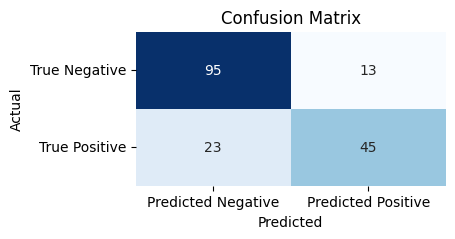

In [49]:
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Here analyzing above confusion matrix:

- TN = 96; 96 negative examples were correctly predicted as negative
- FP = 12; 12 negative examples were incorrectly predicted as positive
- FN = 22; 22 positive examples were incorrectly predicted as negative
- TP = 46; 46 positive examples were correctly predicted as positive.

In [50]:
## Checking precision result
precision = precision_score(y_test, y_pred)
print(f"Our model is {precision*100:.3f} % precised.")

Our model is 77.586 % precised.


In [51]:
## Checking recall result
recall = recall_score(y_test, y_pred)
print(f"{recall*100:.3f} %")

66.176 %


In [52]:
## harmonic mean between precision and recall:
f1_score(y_test, y_pred)

0.7142857142857143

#### Let's do hyperparameter tuning  to find best result

In [53]:
hyperparameter = {
    "penalty":['l1','l2'],
    "solver":['liblinear'],
    "class_weight":[None,'balanced'],
    "max_iter":[50,100,200,500]
}

In [54]:
f1_scorer = make_scorer(f1_score)

In [55]:
grid_search  = GridSearchCV(estimator=logReg, param_grid=hyperparameter, cv=3, scoring=f1_scorer)

In [56]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_iter': [50, 100, 200, 500],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring=make_scorer(f1_score, response_method='predict'))

In [57]:
logReg.set_params(**grid_search.best_params_)
logReg.fit(X_train, y_train)

LogisticRegression(max_iter=50, penalty='l1', solver='liblinear')

In [58]:
logReg.score(X_test, y_test)

0.7954545454545454

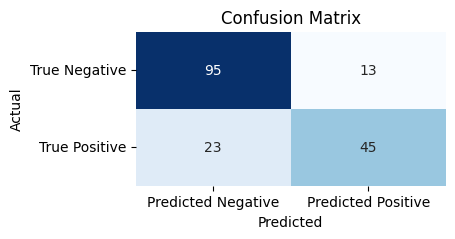

In [59]:
plt.figure(figsize=(4, 2))
sns.heatmap(confusion_matrix(y_test, logReg.predict(X_test)), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()